In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy.special import erfinv
import numpy as np
import random
import math
from tqdm import tqdm

## Tasks 1, 2

Функция генерации выборки с первой практики

In [2]:
def generate_n_random_numbers(N: int, distribution: str):
    """
    N - size of sample
    distribution - ["Uniform[0, 1]", "Uniform[-1, 1]", "2xUniform[-1, 1]", "3xUniform[-1, 1]", "Cauchy(0, 1)", Norm(0, 1)]
    """
    match distribution:
        case "Uniform[0, 1]":
            return [random.uniform(0, 1) for _ in range(N)]
        case "Uniform[-1, 1]":
            return [random.uniform(0, 1) * 2 - 1 for _ in range(N)]
        case "2xUniform[-1, 1]":
            t = generate_n_random_numbers(2 * N, "Uniform[-1, 1]")
            return [t[2 * i] + t[2 * i + 1] for i in range(N)]
        case "3xUniform[-1, 1]":
            t = generate_n_random_numbers(3 * N, "Uniform[-1, 1]")
            return [t[3 * i] + t[3 * i + 1] + t[3 * i + 2] for i in range(N)]
        case "Cauchy(0, 1)":
            t = generate_n_random_numbers(N, "Uniform[0, 1]")
            return list(map(lambda x: math.tan(math.pi * (x - 0.5)), t))
        case "Norm(0, 1)":
            return [random.normalvariate(0, 1) for _ in range(N)]
        case _:
            return []

Зададим константы, которые понадобятся далее

In [3]:
P = 0.95
PERCENTILE = ((1 - P) / 2) * 100
ANALYTICAL_EXPECTATION = 0
ITERATIONS = 10 ** 3
BOOTSTRAP_SIZE = 1000
# NS = [10, 100]
min_sample_size = 10
max_sample_size = 1000
num_of_sample_sizes = 10
log_base = 5
NS = list(map(int, np.logspace(base=log_base, start=math.log(min_sample_size, log_base), stop=math.log(max_sample_size, log_base), num=num_of_sample_sizes)))
print(NS)

[10, 16, 27, 46, 77, 129, 215, 359, 599, 1000]


 Зададим функции, определяющие границы доверительного интервала по выборке разными способами. Все функции принимают в качестве аргумента выборку и возвращают кортеж из двух чисел - левая и правая границы доверительного интервала для матожидания. 

Функция подсчёта доверительного интервала (1)

In [4]:
def calculate_c_star(x: list):
    return sum(x) / len(x)

In [5]:
def confidence_interval_1(sample: list, sigma_squared: float) -> tuple:
    quantil = sps.norm(loc=0, scale=1).ppf((1 + P) / 2)
    term = quantil * math.sqrt(sigma_squared) / math.sqrt(len(sample))
    c_star = calculate_c_star(sample)
    return (c_star - term, c_star + term)

Функция подсчёта доверительного интервала (2)

In [6]:
def calculate_sigma_star(x: list):
    c_star = calculate_c_star(x)
    return math.sqrt(sum([pow(xi - c_star, 2) for xi in x]) / (len(x) - 1))

In [7]:
def confidence_interval_2(sample: list) -> tuple:
    n = len(sample)
    c_star = calculate_c_star(sample)
    term = sps.t.ppf((1 + P) / 2, n - 1) * calculate_sigma_star(sample) / math.sqrt(n) 
    return (c_star - term, c_star + term)

Функция подсчёта доверительного интервала (3)

In [8]:
def calculate_D_coef(n: int, p: float) -> float:
    return math.sqrt(-(math.log((1 - p) / 2) / (2 * n))) - (1 / (6 * n))

In [9]:
def confidence_interval_3(sample: list, shift=0) -> tuple:
    n = len(sample)
    sample = sorted(sample)
    a, b = sample[shift], sample[-shift - 1]
    c_star = calculate_c_star(sample)
    term = (b - a) * calculate_D_coef(n, P)
    return (c_star - term, c_star + term)

Функция подсчёта доверительного интервала методом бутстрэппинга

In [10]:
def confidence_interval_bootstrap(sample: list) -> tuple:
    bootstrap_samples = bootstrap(sample)
    bootstrap_means = [np.mean(sample) for sample in bootstrap_samples]
    return (np.percentile(bootstrap_means, PERCENTILE),
            np.percentile(bootstrap_means, 100 - PERCENTILE))


def bootstrap(data: list):
    return [np.random.choice(data, size=len(data), replace=True)
            for _ in range(BOOTSTRAP_SIZE)]

Функция подсчёта доверительного интервала методом "складного ножа"

In [11]:
z_score = np.sqrt(2) * erfinv(P)

def confidence_interval_jackknife(sample: list) -> tuple:
    sample_mean = np.mean(sample)
    jack_means = np.apply_along_axis(np.mean, 1, jackknife(sample))
    mean_jack_means = np.mean(jack_means)
    # jackknife bias
    n = len(sample)
    bias = (n - 1) * (mean_jack_means - sample_mean)
    # jackknife standard error
    terms = np.apply_along_axis(lambda x: pow(x - mean_jack_means, 2), 0, jack_means)
    std_err = np.sqrt((n - 1) * np.mean(terms))
    # bias-corrected "jackknifed estimate"
    estimate = sample_mean - bias
    return (estimate - std_err * z_score,
            estimate + std_err * z_score)


def jackknife(data: list):
    return [np.delete(data, i) for i in range(len(data))]

Сгенерируем по $10^3$ выборок разных размеров для каждого распределения и построим графики зависимости границ доверительного интервала от размера выборки $n$.

In [12]:
distros = ["Uniform[-1, 1]", "Norm(0, 1)", "2xUniform[-1, 1]"]
sigma_squared = {"Uniform[-1, 1]": 1 / 3,
                 "Norm(0, 1)": 1,
                 "2xUniform[-1, 1]": 2 / 3}
NUM_METHODS = 5

In [13]:
print("Start generating samples...")
samples = {d: [[generate_n_random_numbers(n, d) for _ in range(ITERATIONS)]
                for n in NS] for d in tqdm(distros)}
print("Samples generated.")

Start generating samples...


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Samples generated.


In [14]:
results_a = {d: {method: {} for method in range(NUM_METHODS)} for d in distros}
results_b = {d: {method: {} for method in range(NUM_METHODS)} for d in distros}
for i, d in enumerate(distros):
    for n_id, n in tqdm(enumerate(NS)):
        average_a = [0] * NUM_METHODS
        average_b = [0] * NUM_METHODS
        for sample in samples[d][n_id]:
            a_1, b_1 = confidence_interval_1(sample, sigma_squared[d])
            average_a[0] += a_1
            average_b[0] += b_1

            a_2, b_2 = confidence_interval_2(sample)
            average_a[1] += a_2
            average_b[1] += b_2

            a_3, b_3 = confidence_interval_3(sample)
            average_a[2] += a_3
            average_b[2] += b_3

            a_4, b_4 = confidence_interval_bootstrap(sample)
            average_a[3] += a_4
            average_b[3] += b_4

            a_5, b_5 = confidence_interval_jackknife(sample)
            average_a[4] += a_5
            average_b[4] += b_5

        average_a = np.array(average_a) / len(samples[d][n_id])
        average_b = np.array(average_b) / len(samples[d][n_id])

        for method in range(NUM_METHODS):
            results_a[d][method][n] = average_a[method]
            results_b[d][method][n] = average_b[method]

10it [06:27, 38.78s/it]
10it [06:28, 38.89s/it]
10it [06:26, 38.61s/it]


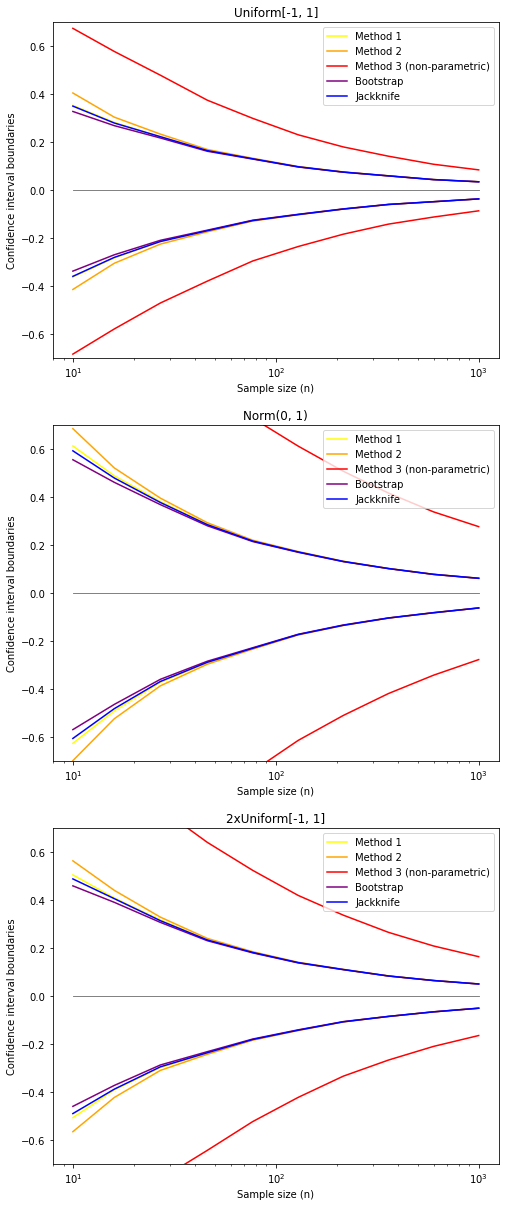

In [29]:
figure, axis = plt.subplots(len(distros), 1, figsize=(8, 7 * len(distros)))
method_colors = {0: "yellow", 1: "orange", 2: "red", 3: "purple", 4: "blue"}
method_names = {0: "Method 1", 1: "Method 2", 2: "Method 3 (non-parametric)", 3: "Bootstrap", 4: "Jackknife"}
for id, d in enumerate(distros):
    for method in range(NUM_METHODS):
        axis[id].plot(NS, results_a[d][method].values(), color=method_colors[method], label=method_names[method])
        axis[id].plot(NS, results_b[d][method].values(), color=method_colors[method])
        axis[id].plot(NS, [0] * len(NS), color='gray', linewidth=0.5)
        
        axis[id].title.set_text(d)
        axis[id].set_xscale('log')
        axis[id].set_xlabel('Sample size (n)')
        axis[id].set_ylabel('Confidence interval boundaries')
        axis[id].set_ylim([-0.7, 0.7])
        axis[id].legend(loc="upper right")

На графиках изображена зависимость границ доверительного интервала от размера выборки $n$. Как и следовало ожидать, интервал самый широкий для непараметрического метода 3.